**Import Libraries and Load the Data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import warnings


In [ ]:
warnings.filterwarnings('ignore')

**Load data**

In [ ]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (1460, 81)
Test data shape: (1459, 80)


**Initial EDA**

In [ ]:

def quick_eda(df):
    print("\n=== Data Overview ===")
    print(df.info())

    print("\n=== Missing Values ===")
    missing = df.isnull().sum().sort_values(ascending=False)
    missing = missing[missing > 0]
    print(missing)

    print("\n=== Numeric Features ===")
    print(df.describe())

    print("\n=== Categorical Features ===")
    print(df.describe(include=['O']))

quick_eda(train_df)



=== Data Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null 

**Visualizations**

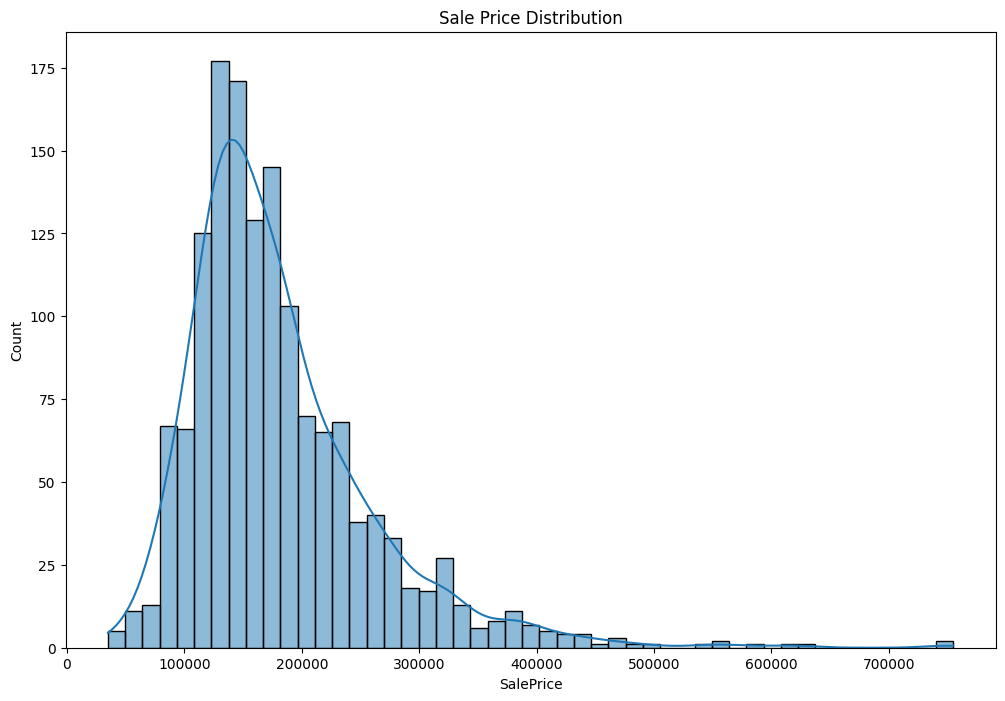

In [25]:
plt.figure(figsize=(12,8))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Sale Price Distribution')
plt.show()

**Correlation analysis**

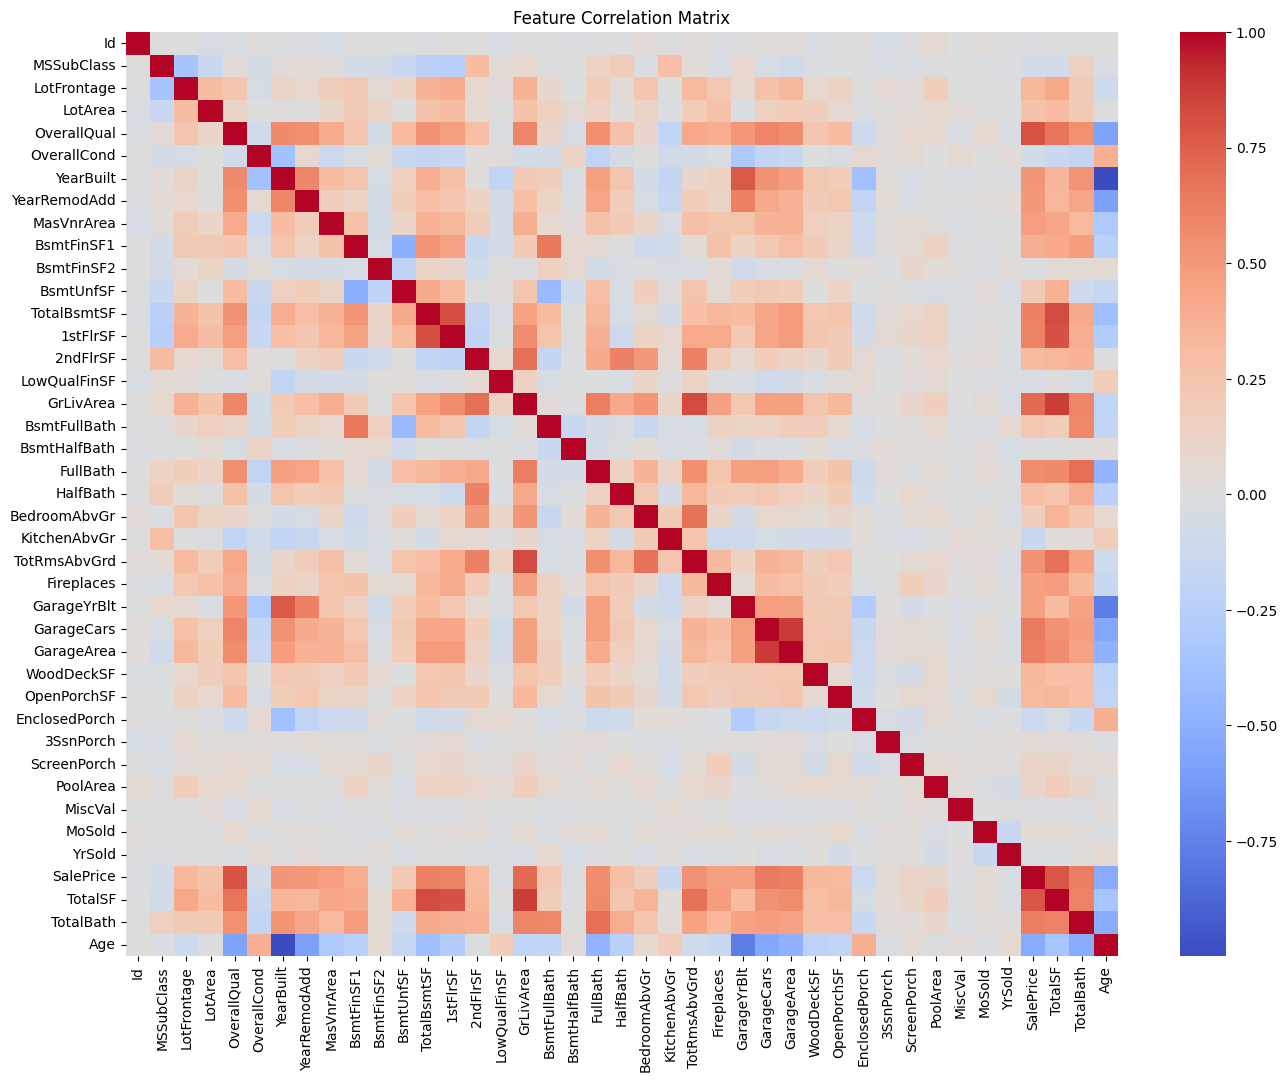

In [27]:
corr_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [33]:
# Top correlated features with SalePrice
top_corr = corr_matrix['SalePrice'].sort_values(ascending=False)[1:11]
print("\nTop 10 features correlated with SalePrice:")
print(top_corr)



Top 10 features correlated with SalePrice:
OverallQual     0.790982
TotalSF         0.782260
GrLivArea       0.708624
GarageCars      0.640409
TotalBath       0.631731
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64


 **Feature Engineering**


In [34]:
def prepare_data(df):
    # Handle missing values
    # Fill numerical missing values with median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)

    # Fill categorical missing values with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Feature transformations
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df['Age'] = df['YrSold'] - df['YearBuilt']

    # Convert categorical to dummy variables
    df = pd.get_dummies(df)

    return df

In [ ]:
# Prepare data
train_processed = prepare_data(train_df)


In [ ]:
# Select features based on correlation
selected_features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    'FullBath', 'YearBuilt', 'TotalSF', 'TotalBath', 'Age',
    'TotRmsAbvGrd', 'Fireplaces', 'GarageArea'
]

In [36]:
# Add dummy columns that might have been created
features = [f for f in selected_features if f in train_processed.columns] + \
           [col for col in train_processed.columns if 'Neighborhood_' in col]

X = train_processed[features]
y = train_processed['SalePrice']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Modeling**

In [ ]:

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10),
    'Lasso Regression': Lasso(alpha=0.1)
}

results = {}
for name, model in models.items():
    # Create pipeline with standardization
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = pipeline.score(X_test, y_test)

    results[name] = {
        'RMSE': rmse,
        'R2 Score': r2,
        'Model': pipeline
    }

    print(f"\n{name} Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")


Linear Regression Results:
RMSE: 36509.18
R2 Score: 0.8262

Ridge Regression Results:
RMSE: 36451.94
R2 Score: 0.8268

Lasso Regression Results:
RMSE: 36508.41
R2 Score: 0.8262


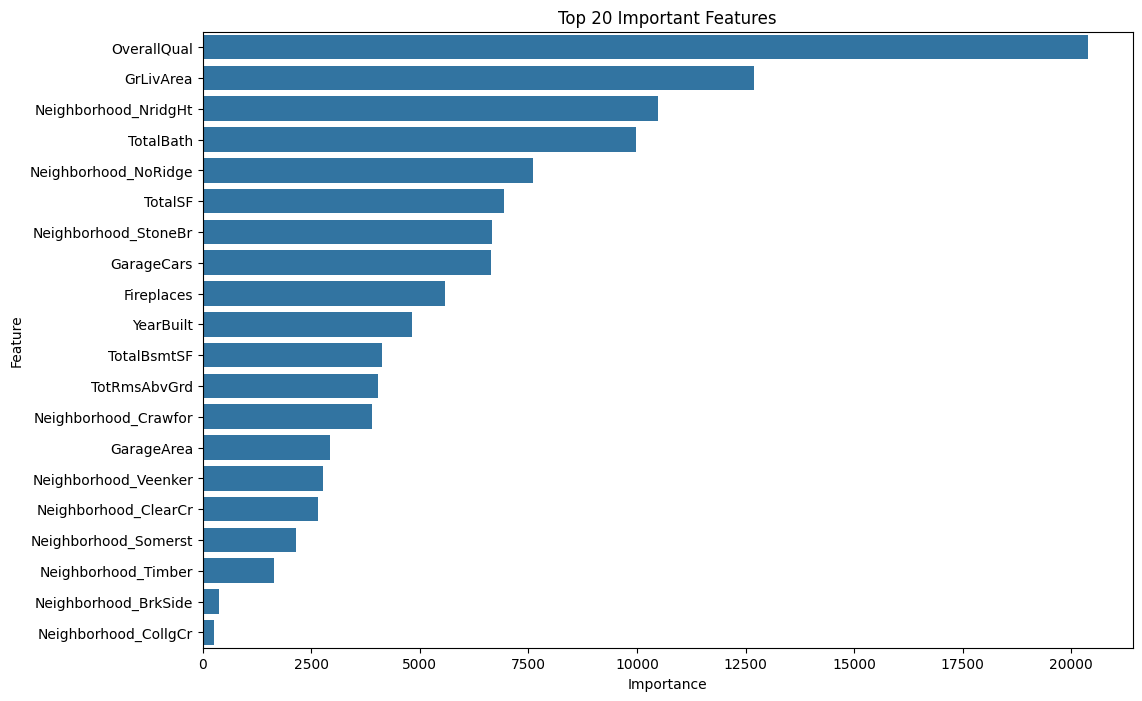

In [ ]:
# Feature importance for the best model
best_model = results['Ridge Regression']['Model']
coefficients = best_model.named_steps['ridge'].coef_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': coefficients
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Important Features')
plt.show()


In [ ]:
# Make predictions on test set (for Kaggle submission)
test_processed = prepare_data(test_df)
X_kaggle_test = test_processed[features]


In [ ]:
# Ensure all columns are present (some neighborhoods might be missing)
missing_cols = set(X.columns) - set(X_kaggle_test.columns)
for col in missing_cols:
    X_kaggle_test[col] = 0
X_kaggle_test = X_kaggle_test[X.columns]  # Ensure same column order

final_predictions = best_model.predict(X_kaggle_test)


In [ ]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': final_predictions
})
submission.to_csv('data/submission.csv', index=False)
print("\nSubmission file created!")


Submission file created!
